# Paper: STELAR: Spatio-temporal Tensor Factorization with Latent Epidemiological Regularization

[Homepage](https://nkargas.github.io/)

In this work, we show how we can use tensor decomposition to predict the evolution of epidemic trends for many regions simultaneously. Given case counts data for different locations and signals such as number of daily new infections, number of hospitalized patients, (ICU) patients, the problem of interest is to model and predict the evolution of these signals over time.

<img src="./images/motivation.png" alt="motivation" style="width: 600px"/>

We can model our data using a $3$-dimensional spatio-temporal array $\underline{\mathbf{X}} \in \mathbb{R}^{M \times N \times T}$ which is indexed by (location, signal, time) in which we store the case counts of the different signals. Our goal is to make accurate long-term predictions i.e., predict future frontal slabs of $\underline{\mathbf{X}}$. 

We develop a nonnegative tensor factorization method with latent epidemiological model regularization. Our method enables long-term prediction by incorporating latent temporal regularization through a system of discrete time difference equations of a widely adopted epidemiological model.

### Contents:
- [Dataset](#dataset) 
- [SIR](#sir_model) 
- [STELAR](#stelar) 
- [Training our model](#training) 
- [Results](#results) 

## Dataset <a id='dataset'></a> 

In [1]:
from covid19dh import covid19
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from scipy import optimize
from collections import deque
import itertools
import scipy
import functools
import pandas as pd

For this demo we will use the covid19dh library (https://github.com/covid19datahub/Python). 

We will use $N=4$ signals from $M=52$ locations.

We set the time window to be [2020-04-01, 2020-07-10], $T=100$. 

Below we download the data and construct tensor $\underline{\mathbf{X}} \in \mathbb{R}^{M \times N \times T}$.

In [2]:
start_date = "2020-04-01"
end_date = "2020-07-10"

df, _ = covid19("USA", verbose=False, raw=False, level=2, start=start_date, end=end_date)
df = df[['administrative_area_level_2', 'date', 'confirmed', 'deaths', 'tests', 'hosp']]

states = df['administrative_area_level_2'].unique()

# Create the tensor
mytensor = df.iloc[:, 2:].values
mytensor = mytensor.reshape(df['administrative_area_level_2'].nunique(), df['date'].nunique(), -1)
mytensor = np.transpose(mytensor, (0, 2, 1))

for s in range(3):
    mytensor[:, s, 1:] = np.diff(mytensor[:, s, :]).clip(0)
mytensor = mytensor[:, :, 1:]

# Remove states for which we don't have data
non_zero_signals = np.where(np.all(np.sum(mytensor, axis=2) != 0, axis=1))
states = states[non_zero_signals]
signals = np.array(['New infections', 'Deaths', 'Tests', 'Hospitalization'])
mytensor = mytensor[non_zero_signals]

# Normalize data
max_values = np.max(mytensor, axis=2)
mytensor = mytensor / max_values[:, :, np.newaxis]

An example of how the data looks like after normalization.

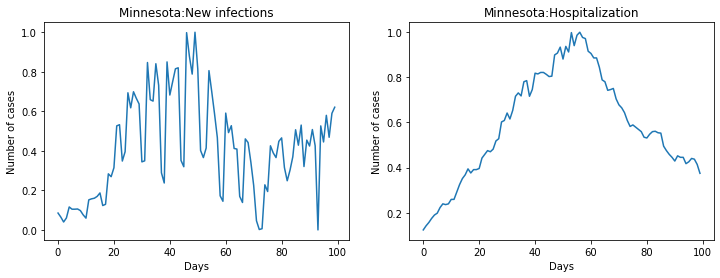

In [3]:
state = states[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mytensor[0, 0, :])
plt.title(state + ':' + signals[0])
plt.ylabel('Number of cases')
plt.xlabel('Days')

plt.subplot(1, 2, 2)
plt.plot(mytensor[0, 3, :])
plt.title(state + ':' + signals[3])
plt.ylabel('Number of cases')
plt.xlabel('Days')

plt.show()

## SIR <a id='sir_model'></a> 

The SIR model (Kermack and McKendrick 1927) is one of the most famous and paradigmatic models in mathematical epidemiology. In this model, a population is divided into susceptible, infected and recovered subpopulations. The evolution of these quantities is described by the following equations: 

\begin{align}
& S(t) - S(t-1) = - \beta S(t-1) I(t-1)/N,  \label{eq:dS}                     \\
& I(t) - I(t-1) =  \beta S(t-1) I(t-1)/N- \gamma I(t-1), \label{eq:dI}\\
& R(t) - R(t-1) = \gamma I(t-1),
\end{align}

where $S(t)$, $I(t)$ and $R(t)$ stand for the size of susceptible, infected and recovered populations at time $t$, respectively and  $N = S(t) + I(t) + R(t) $  is the total population. The parameter $\beta$ controls the rate of spread and the parameter $\gamma$ is the recovery rate, so its inverse $1/\gamma$ represents the average time period that an infected individual remains infectious. 

The quantity $\beta S(t) / N$ is the fraction of susceptible individuals that will contact an infected individual at time $t$. Therefore the new infections at time $t$ are given by

\begin{equation}
C(t) := \beta S(t)I(t)/N.
\end{equation}

Below we define the SIR model and perform curve fitting on $C(t)$.

In [4]:
class SIR:
    # Lower and upper bounds for s0, i0, \beta and \gamma
    def __init__(self, bounds=([0, 0, 1e-10, 1e-10], [np.inf, np.inf, 1, 1])):
        self.bounds = bounds
        self.data = None

    # Predicts the daily infected cases C(t)
    def predict(self, time_full, s0, i0, beta, gamma):
        s = np.zeros(len(time_full))
        i = np.zeros(len(time_full))
        s[0], i[0] = s0, i0
        for t in time_full[1:]:
            s[t] = max(s[t - 1] - beta * s[t - 1] * i[t - 1], 0)
            i[t] = i[t - 1] + beta * s[t - 1] * i[t - 1] - gamma * i[t - 1]
        return beta * s * i

    # Predicts susceptible, infected and recovered populations
    def predict_all(self, time_full, s0, i0, beta, gamma):
        s = np.zeros(len(time_full))
        i = np.zeros(len(time_full))
        r = np.zeros(len(time_full))
        s[0], i[0] = s0, i0
        for t in time_full[1:]:
            s[t] = s[t - 1] - beta * s[t - 1] * i[t - 1]
            i[t] = i[t - 1] + beta * s[t - 1] * i[t - 1] - gamma * i[t - 1]
            r[t] = r[t - 1] + gamma * i[t - 1]
        return s, i, r, beta * s * i

    # Curve fitting to find parameters s0, i0, \beta and \gamma based on observed daily new infections
    def fit(self, data, init):
        self.data = data
        time_full = range(data.shape[0])
        popt, pcov = optimize.curve_fit(self.predict, time_full, self.data, bounds=self.bounds, p0=init, maxfev=150000)
        return popt

### Toy example

We define the parameters of an SIR model and generate synthetic data. 

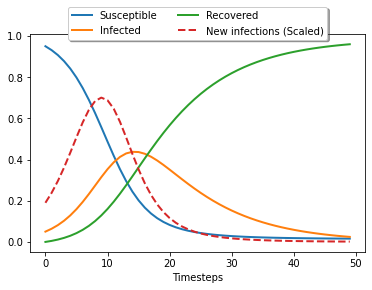

In [5]:
s0, i0, r0 = 0.95, 0.05, 0
beta, gamma = 0.4, 0.1
sir_model = SIR()

time_steps = 50
time_full = range(time_steps)
s, i, r, c = sir_model.predict_all(time_full, s0, i0, beta, gamma)

plt.figure()
plt.plot(time_full, s, linewidth=2, label='Susceptible')
plt.plot(time_full, i, linewidth=2, label='Infected')
plt.plot(time_full, r, linewidth=2, label='Recovered')
plt.plot(time_full, 10 * c, '--', linewidth=2, label='New infections (Scaled)')
plt.xlabel('Timesteps')
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True, ncol=2)
plt.show()

We learn the parameters of the model given observed noisy data.

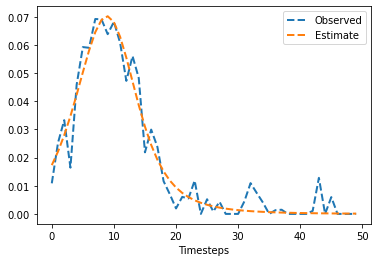

Estimated parameters: 0.901,0.041,0.465,0.116


In [6]:
# Add noise
c_observed = np.maximum(c + 7e-3 * np.random.randn(len(c)), 0)

# Curve fitting
s0_est, i0_est, beta_est, gamma_est = sir_model.fit(c_observed, [0.5, 0.5, 0.2, 0.2])
_, _, _, c_est = sir_model.predict_all(time_full, s0_est, i0_est, beta_est, gamma_est)
plt.figure()
plt.plot(time_full, c_observed, '--', linewidth=2, label='Observed')
plt.plot(time_full, c_est, '--', linewidth=2, label='Estimate')
plt.xlabel('Timesteps')
plt.legend()
plt.legend()
plt.show()

print(f'Estimated parameters: {s0_est:.3f},{i0_est:.3f},{beta_est:.3f},{gamma_est:.3f}')

SIR does not require much training data but it is very restrictive.

## STELAR <a id='stelar'></a> 

STELAR a data efficient and interpretable method based on constrained nonnegative tensor factorization. STELAR solves the following optimization problem:

<img src="./images/formulation.png" alt="formulation" style="width: 650px"/>

The first term is the data fitting term. We fit a CPD model of rank-K with nonnegativity constraints on the factors. The second term is Frobenius norm regularization which is typically used to avoid overfitting and improve generalization of the model. We introduce a third term which regularizes each column of the factor matrix $\mathbf{C}$ according to the new infections curve of an SIR model.


Adding latent temporal regularization through an SIR model offers significant advantages compared to having separate SIR models for each location. Our model can capture correlations between different locations and signals through their latent representations and therefore improve the prediction accuracy. Additionally, it enables expressing the evolution of a signal as weighted sum of K separate SIR model. 

<img src="./images/elementwise.png" alt="model_output" style="width: 350px"/>

In [7]:
class STELAR:

    def __init__(self, rank, mu=0, nu=0, max_iter=100, inner_max_itr=10):
        # Model hyperparameters
        self.rank = rank
        self.mu = mu
        self.nu = nu

        # Maximum number of outer and inner iterations
        self.max_iter, self.inner_max_itr = max_iter, inner_max_itr

        # Early stopping
        self.max_iter_no_impr = 5

        # Input tensor
        self.x_norm, self.ndim, self.shape = [None] * 3

        # Factor matrices
        self.U, self.U_d, self.UtU = [], [], []

        # SIR model parameters
        self.beta, self.gamma = None, None
        self.s0, self.i0 = None, None
        self.sir_model = SIR()

        # Track RMSE error for validation set
        self.rmse_valid = deque([float('Inf')], maxlen=self.max_iter_no_impr)

        # Track cost
        self.cost_fit_hist, self.cost_l2_reg_hist, self.cost_sir_reg_hist = [], [], []

    # Predict future rows of C
    def predict_s_i_c(self, time_steps):
        s_est = np.zeros((time_steps, self.rank))
        i_est = np.zeros((time_steps, self.rank))
        s_est[0], i_est[0] = self.s0, self.i0
        for t in range(1, time_steps):
            s_est[t] = s_est[t - 1] - self.beta * s_est[t - 1] * i_est[t - 1]
            i_est[t] = i_est[t - 1] + self.beta * s_est[t - 1] * i_est[t - 1] - self.gamma * i_est[t - 1]
        c_est = s_est * i_est * self.beta
        return s_est, i_est, c_est

    # Inner product for efficient cost computation
    def inner_prod(self, x):
        res = np.zeros(self.rank)
        for r in range(self.rank):
            tmp = x
            for n in range(self.ndim):
                tmp = np.tensordot(tmp, self.U[n][:, r], axes=(0, 0))
            res[r] = tmp
        return res.sum()

    # Norm of the low-rank tensor
    def norm(self):
        return np.sqrt(functools.reduce(np.multiply, ([self.U[n].T @ self.U[n] for n in range(self.ndim)])).sum())

    # Compute cost function value
    def cost(self, x, c_est):
        cost_fit = self.x_norm ** 2 - 2 * self.inner_prod(x) + self.norm() ** 2
        cost_l2_reg = self.mu * sum([linalg.norm(self.U[n]) ** 2 for n in range(self.ndim)])
        cost_sir_reg = self.nu * linalg.norm(self.U[2] - c_est) ** 2
        return cost_fit, cost_l2_reg, cost_sir_reg

    # ADMM subproblem
    def ao_admm_sub(self, WtW, WtY, U, U_d):
        rho = np.trace(WtW) / self.rank
        cholesky_l = np.linalg.cholesky(WtW + rho * np.eye(self.rank))

        for itr in range(self.inner_max_itr):
            # primal updates
            U_t = scipy.linalg.solve_triangular(cholesky_l, WtY + rho * (U + U_d).T, lower=True)
            U_t = scipy.linalg.solve_triangular(cholesky_l.T, U_t)
            U = (U_t.T - U_d).clip(min=0)
            # dual update
            U_d = U_d + U - U_t.T
        return U, U_d

    # Predict num_days ahead after training the model
    def predict(self, num_days):
        _, _, U_time_est = self.predict_s_i_c(num_days)
        U_est = [self.U[0], self.U[1], U_time_est]
        x_est = np.reshape((U_est[0]) @ khatrirao(U_est, 0).T, [self.shape[0], self.shape[1], U_time_est.shape[0]])
        return x_est

    # Fit the model
    def fit(self, x, x_valid):
        self.x_norm = linalg.norm(x)
        self.ndim = x.ndim
        self.shape = x.shape

        # STELAR model initialization
        self.U = [np.random.rand(self.shape[n], self.rank) for n in range(self.ndim)]
        self.U_d = [np.zeros((self.shape[n], self.rank)) for n in range(self.ndim)]
        self.UtU = [self.U[n].T @ self.U[n] for n in range(self.ndim)]

        # SIR model for each column of C
        self.beta = [1e-3] * self.rank
        self.gamma = [1e-1] * self.rank
        self.i0 = [10] * self.rank
        self.s0 = [50] * self.rank

        for itr in range(self.max_iter):

            # Update A
            UtU_mult = np.ones((self.rank, self.rank))
            for k in range(self.ndim):
                if k != 0:
                    UtU_mult = UtU_mult * self.UtU[k]
            WtW = UtU_mult + self.mu * np.eye(self.rank)
            WtY = mtkrprod(x, self.U, 0).T
            self.U[0], self.U_d[0] = self.ao_admm_sub(WtW, WtY, self.U[0], self.U_d[0])
            self.UtU[0] = self.U[0].T @ self.U[0]

            # Update B
            UtU_mult = np.ones((self.rank, self.rank))
            for k in range(self.ndim):
                if k != 1:
                    UtU_mult = UtU_mult * self.UtU[k]
            WtW = UtU_mult + self.mu * np.eye(self.rank)
            WtY = mtkrprod(x, self.U, 1).T
            self.U[1], self.U_d[1] = self.ao_admm_sub(WtW, WtY, self.U[1], self.U_d[1])
            self.UtU[1] = self.U[1].T @ self.U[1]

            # Update C
            s_est, i_est, c_est = self.predict_s_i_c(self.U[2].shape[0])
            UtU_mult = np.ones((self.rank, self.rank))
            for k in range(self.ndim):
                if k != 2:
                    UtU_mult = UtU_mult * self.UtU[k]
            WtW = UtU_mult + self.nu * np.eye(self.rank) + self.mu * np.eye(self.rank)
            WtY = mtkrprod(x, self.U, 2).T + self.nu * c_est.T
            self.U[2], self.U_d[2] = self.ao_admm_sub(WtW, WtY, self.U[2], self.U_d[2])
            self.UtU[2] = self.U[2].T @ self.U[2]

            # Update SIR model of the C factor
            for r in range(self.rank):
                init_sir = [self.s0[r], self.i0[r], self.beta[r], self.gamma[r]]
                self.s0[r], self.i0[r], self.beta[r], self.gamma[r] = self.sir_model.fit(self.U[2][:, r], init_sir)
            s_est, i_est, c_est = self.predict_s_i_c(self.U[2].shape[0])

            # Update cost
            cost_fit, cost_l2_reg, cost_sir_reg = self.cost(x, c_est)
            self.cost_fit_hist.append(cost_fit)
            self.cost_l2_reg_hist.append(cost_l2_reg)
            self.cost_sir_reg_hist.append(cost_sir_reg)

            # Prediction
            stelar_val_est = self.predict(x.shape[2] + x_valid.shape[2])
            stelar_val_est = stelar_val_est[:, 0, x.shape[2]: x.shape[2] + x_valid.shape[2]]

            if rmse(x_valid[:, 0, :], stelar_val_est) > max(self.rmse_valid):
                return self.rmse_valid[-1]

            self.rmse_valid.append(rmse(x_valid[:, 0, :], stelar_val_est))
            print(f'Iteration {itr}: val rmse: {self.rmse_valid[-1]}')

        return self.rmse_valid[-1]

In [8]:
def rmse(x, y):
    return np.sqrt(np.sum(np.linalg.norm(x - y) ** 2) / x.size)


def mae(x, y):
    return np.sum(np.abs(x - y)) / x.size


def khatrirao(u, skip=None):
    if len(u) == 1:
        return u[0]

    n_cols = u[0].shape[1]
    if skip is not None:
        u = [u[n] for n in range(len(u)) if n != skip]

    n_rows = np.prod([u[n].shape[0] for n in range(len(u))])
    x = np.zeros((n_rows, n_cols))
    for r in range(n_cols):
        v = u[0][:, r]
        for n in range(1, len(u)):
            v = np.kron(v, u[n][:, r])
        x[:, r] = v
    return x


def unfold(x, mode):
    return np.reshape(np.moveaxis(x.data, mode, 0), (x.shape[mode], -1))


def mtkrprod(x, u, mode):
    return unfold(x, mode) @ khatrirao(u, skip=mode)

## Training our model <a id='training'></a> 

In [9]:
np.random.seed(0)

num_days_train, num_days_valid, num_days_test = 87, 3, 10
num_days = num_days_train + num_days_valid + num_days_test

# --------------------- Compute decomposition --------------------------------------------
mytensor_training = mytensor[:, :, :num_days_train]
mytensor_valid = mytensor[:, :, num_days_train:num_days_train + num_days_valid]
mytensor_test = mytensor[:, :, num_days_train + num_days_valid: num_days]

stelar_model_predictions = None
best_score = float('Inf')
rank = [20]
mu = [1e-3]
nu = [1e-2]

for param in itertools.product(rank, nu, mu):
    stelar_model = STELAR(rank=param[0], nu=param[1], mu=param[2], max_iter=50, inner_max_itr=50)
    val_err = stelar_model.fit(mytensor_training, mytensor_valid)
    if val_err < best_score:
        best_score = val_err
        best_model = stelar_model

stelar_model_predictions = best_model.predict(num_days)
rmse_stelar = rmse(stelar_model_predictions[:, 0, num_days - num_days_test:], mytensor_test[:, 0, :])
mae_stelar = mae(stelar_model_predictions[:, 0, num_days - num_days_test:], mytensor_test[:, 0, :])
print(f'RMSE STELAR : {rmse_stelar}, MAE STELAR : {mae_stelar}')

Iteration 0: val rmse: 0.2821295405800961
Iteration 1: val rmse: 0.21078913227663287
Iteration 2: val rmse: 0.19084163389315614
Iteration 3: val rmse: 0.18435097618225435
Iteration 4: val rmse: 0.17470704722016167
Iteration 5: val rmse: 0.17125629926654137
Iteration 6: val rmse: 0.1696453009629452
Iteration 7: val rmse: 0.1692313157270461
Iteration 8: val rmse: 0.169052174349604
Iteration 9: val rmse: 0.16963777126156487
Iteration 10: val rmse: 0.17071904413865793
RMSE STELAR : 0.23630944453084954, MAE STELAR : 0.16841661892861245


## Results <a id='results'></a> 

### 10 days forecasting

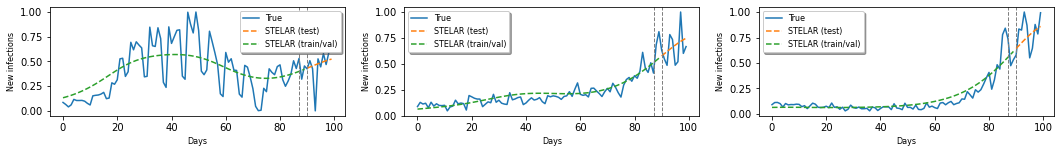

In [10]:
plt.figure(figsize=(18,14))
sig = 0
for s in range(3):
    ax = plt.subplot(6, 3, s+1)
    ax.plot(range(num_days), mytensor[s, sig, :], label='True')
    ax.plot(range(num_days-num_days_test, num_days), stelar_model_predictions[s, sig, num_days-num_days_test:], '--', label='STELAR (test)')
    ax.plot(range(num_days_train+num_days_valid), stelar_model_predictions[s, sig, :num_days_train+num_days_valid], '--', label='STELAR (train/val)')
    ax.axvline(x=num_days_train, linewidth=1, linestyle='--', color='grey')
    ax.axvline(x=num_days_train+num_days_valid, linewidth=1, linestyle='--', color='grey')
    ax.legend(fontsize=8, shadow=True)
    ax.set_xlabel('Days', fontsize=8)
    ax.set_ylabel('New infections', fontsize=8)
plt.show()

### Visualization of strongest components

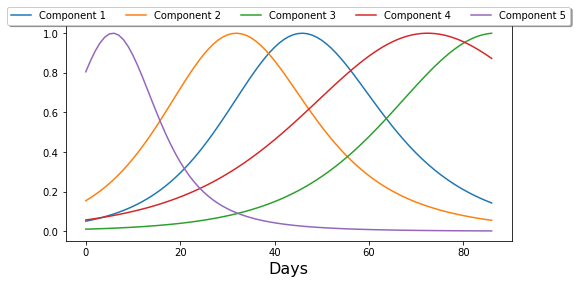

In [11]:
_, _, c_est = best_model.predict_s_i_c(best_model.U[2].shape[0])
stelar_model =None
# Normalization of each column
w = np.ones(best_model.rank)
A = best_model.U[0].copy()
B = best_model.U[1].copy()
C = best_model.U[2].copy()

for r in range(best_model.rank):
    w[r] = w[r] * np.linalg.norm(best_model.U[0][:, r]) * np.linalg.norm(best_model.U[1][:, r]) * np.linalg.norm(best_model.U[2][:, r])
    A[:, r] = best_model.U[0][:, r] / np.linalg.norm(best_model.U[0][:, r])
    B[:, r] = best_model.U[1][:, r] / np.linalg.norm(best_model.U[1][:, r])
    c_est[:, r] = c_est[:, r] / np.linalg.norm(best_model.U[2][:, r])
    C[:, r] = best_model.U[2][:, r] / np.linalg.norm(best_model.U[2][:, r])

# Keep the strongest k components
k = 5
idx = np.argsort(w / sum(w))[::-1]
weights = w[idx] / sum(w)
A = A[:, idx]
B = B[:, idx]
C = C[:, idx]
c_est = c_est[:, idx[:k]]

plt.figure(figsize=(8,4))
for r in range(k):
    plt.plot(c_est[:, r]/np.max(c_est[:, r]), label=f'Component {r + 1}')
plt.xlabel('Days', fontsize=16)
plt.legend(loc='upper center', prop={'size': 10}, bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, ncol=k)
plt.show()

top_states_per_component = []
top_signals_per_component = []

for r in range(k):
    top_states_per_component.append(states[np.argsort(A[:, r])[-1:-11:-1]])

for r in range(k):
    top_signals_per_component.append(signals[np.argsort(B[:, r])[::-1]])

States that contribute more to each component.

In [12]:
df1 = pd.DataFrame(np.array(top_states_per_component).T)  
df1.columns = [f'component {r+1}' for r in range(k)]
print(df1.to_markdown()) 

|    | component 1          | component 2    | component 3    | component 4   | component 5   |
|---:|:---------------------|:---------------|:---------------|:--------------|:--------------|
|  0 | Indiana              | Wyoming        | Virgin Islands | New York      | Louisiana     |
|  1 | Ohio                 | Puerto Rico    | Utah           | Vermont       | Guam          |
|  2 | Iowa                 | Virgin Islands | North Carolina | Maryland      | Washington    |
|  3 | Maryland             | West Virginia  | South Dakota   | Colorado      | New York      |
|  4 | Minnesota            | Oregon         | Kentucky       | Illinois      | Colorado      |
|  5 | Virginia             | Mississippi    | Nebraska       | Michigan      | Wisconsin     |
|  6 | District of Columbia | Delaware       | Mississippi    | Wisconsin     | Connecticut   |
|  7 | Maine                | Louisiana      | Arkansas       | Indiana       | New Jersey    |
|  8 | New Hampshire        | Massachuse

Signals that contribute more to each componnent.

In [13]:
df2 = pd.DataFrame(np.array(top_signals_per_component).T)  
print(df2.to_markdown()) 

|    | 0               | 1               | 2               | 3               | 4               |
|---:|:----------------|:----------------|:----------------|:----------------|:----------------|
|  0 | Hospitalization | Hospitalization | Hospitalization | Tests           | Hospitalization |
|  1 | New infections  | Tests           | Tests           | Hospitalization | New infections  |
|  2 | Deaths          | Deaths          | Deaths          | Deaths          | Tests           |
|  3 | Tests           | New infections  | New infections  | New infections  | Deaths          |
